# Analysis

## Setup

In [16]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings

The 'ecrest' class has been imported from eCREST_cli.py

An instance of this object will be able to:
- open an neuroglancer viewer for proofrieading (see "Proofread using CREST")
    - add-remove segments (using graph feature for efficiency)
    - format itself and save itself as a CREST-style .json
- convert from neuroglancer json (see "Convert From Neuroglancer to eCREST")
    - format itself and save itself as a CREST-style .json
    


### Import settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [70]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

In [71]:
dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

## Get all cells info

In [73]:
nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child

cell_type = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

## Get all segments

In [74]:

# Create a base_segments dictionary of all reconstructed cells 
'''
when done, can this be saved as a json? maybe quicker to load than to re-go through all cells?
'''

base_segments = {}
for x in nodes:
    # if cell_type[x] in network_types: # if do this, you can't check if the post-syn segments exist as a reconstruction
    cell = ecrest(settings_dict,filepath = nodefiles[x])#,launch_viewer=False)
    base_segments[cell.cell_data['metadata']['main_seg']['base']] = cell.cell_data['base_segments']

In [17]:
# # # IF NEED TO CELL TYPE....


# json_path = Path(settings_dict['save_dir'])
# filename = 'cell_graph_644143297__2023-04-18 20.22.35.json'
# filepath = json_path / filename

# crest = ecrest(settings_dict,filepath= filepath)#, launch_viewer=False)


# # Assign the cell type and which method you are using (manual or auto)
# cell_type = 'mg1'
# method = 'manual'

# ## Do not edit
# crest.define_ctype(cell_type,method)

# crest.save_cell_graph(directory_path = filepath.parent, file_name=filepath.name, save_to_cloud=False); 

Saved cell 644143297 reconstruction locally at 2023-04-19 16.57.21


## Build Graph

In [23]:
network_types = ['mg1','mg2','mgx','lg','lf','lx']

In [28]:
ell = ig_Graph(directed = True) 
ell.add_vertices([n for n in nodes if cell_type[n] in network_types])

# assign cell types to each node
for x in ell.vs:
    x['cell_type'] = cell_type[x['name']]

In [ ]:
# use this code cell to delete some of the vertices (cells)

# to_delete_ids = [v.index for v in ell.vs if v['cell_type'] not in ['mg2','lg','mg1','lf','lx','mgx']]
# ell.delete_vertices(to_delete_ids)

In [29]:
## find edges and set the cell-structure attribute of the edge based on which part of the cell the edge goes to
edge_list = []
cells_with_synapses = []
cells_without_synapses = []
# for each node,
for x_pre in ell.vs:
# x_pre = ell.vs.find('128473437')

    # if the node has post-synaptic annotations (the current cell is assumed pre-synaptic)
    pre = ecrest(settings_dict,filepath = nodefiles[x_pre['name']])#,launch_viewer=False)
    if pre.cell_data['end_points']['post-synaptic'] != []:
        
        cells_with_synapses.append([x_pre['name'],x_pre['cell_type'],len(pre.cell_data['end_points']['post-synaptic'])])
        
        # for each synapse
        for syn_ in pre.cell_data['end_points']['post-synaptic']:
            try:
                post_seg = syn_[3]

                # go through each other nodes
                for x_post in ell.vs:
                    post = base_segments[x_post['name']] #ecrest(settings_dict,filepath = nodefiles[x_post['name']],launch_viewer=False)

                    for k,v in post.items():

                        for v_ in list(v): #find keys (can be multiple on the same cell) for matching segment ids
                            if post_seg == v_: 
                                # add edge to the graph between current node and matching node
                                edge_list.append([x_pre['name'],x_post['name'],k])

            except IndexError as msg:
                cellid = x_pre['name']
                print(msg, f'for cell {cellid} synapse at syn_ has no segment id')

    else:
        cells_without_synapses.append([x_pre['name'],x_pre['cell_type'],len(pre.cell_data['end_points']['post-synaptic'])])
        cellid = x_pre['name']
        # print(f'no synapses for {cellid}')
        

In [30]:
print(f'{len(ell.vs)} cells in the network that fall within cell types of interest (nodes in the graph):')
print('')
for ctype in ['lf','lg','mg1','mg2','lx','mgx']:
    these_cells = ell.vs.select(lambda v: ctype in v['cell_type'])
    print(f'{len(these_cells)} {ctype} cells.')# {len(ell.vs.select(lambda v: 'lg' in v['cell_type']))} lg cells. {len(e
print('')

df_allsyn = pd.DataFrame(cells_with_synapses)
print(f'{len(df_allsyn[df_allsyn[1].str.contains("mg")])} of these are mg_ cells with post-synaptic segments labeled for their synapses')

print(f'{df_allsyn[df_allsyn[1].str.contains("mg")][2].sum()} total post-synapstic segments labeled from mg_ cells in the network')

# cells_without_synapses

df_nosyn = pd.DataFrame(cells_without_synapses)

print(f'{len(df_nosyn[df_nosyn[1].str.contains("mg")])} mg_ cells without labeled synapses')

144 cells in the network that fall within cell types of interest (nodes in the graph):

29 lf cells.
29 lg cells.
38 mg1 cells.
34 mg2 cells.
5 lx cells.
9 mgx cells.

49 of these are mg_ cells with post-synaptic segments labeled for their synapses
3146 total post-synapstic segments labeled from mg_ cells in the network
32 mg_ cells without labeled synapses


### Cell Structures included

If want to count different cell structure targets as unique, use the following cell.  

If not, ignore it

In [8]:
edge_scaling = 10
df = pd.DataFrame(edge_list,columns = ['pre','post','structure'])

df_edges = deepcopy(df.value_counts().reset_index(name='weight'))
df_edges['weight_norm'] = (df_edges['weight'] / df_edges['weight'].max()) * edge_scaling

for i,r in df_edges.iterrows():
    df_edges.loc[i,'pre_type']=ell.vs.find(r['pre'])['cell_type']
    df_edges.loc[i,'post_type']=ell.vs.find(r['post'])['cell_type']

# for each unique edge, get the cell-type pair and structure
for i,r in df_edges.iterrows():
    ell.add_edge(r['pre'],r['post'],weight = r['weight_norm'],structure = r['structure'])

In [32]:
# print(f'comprising {len(df_edges)} unique edges among:')
print(f'{df_edges[["pre_type","post_type","structure"]].value_counts().reset_index(name="counts")["counts"].sum()} unique edges among:')
print(f'{len(df["pre"].unique())} unique pre synaptic cells - to - {len(df["post"].unique())} unique post-synaptic cells (counts different structures on same cell as different)')

In [ ]:
df_edge_counts = df_edges[['pre_type','post_type','structure']].value_counts().reset_index(name='counts')

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['lf'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['lf'])
display(df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['lg'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['lg'])
display(df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['mg2'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['mg2'])
display(df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['mg1'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['mg1'])
display(df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True))

### Ignore cell structure

If just want different cell pairs to count as unique (ignore morphology), use the following cell

In [31]:
edge_list_cell_pairs = [[r[0],r[1]] for r in edge_list]

edge_scaling = 10
df = pd.DataFrame(edge_list_cell_pairs,columns = ['pre','post'])

df_edges = deepcopy(df.value_counts().reset_index(name='weight'))
df_edges['weight_norm'] = (df_edges['weight'] / df_edges['weight'].max()) * edge_scaling

for i,r in df_edges.iterrows():
    df_edges.loc[i,'pre_type']=ell.vs.find(r['pre'])['cell_type']
    df_edges.loc[i,'post_type']=ell.vs.find(r['post'])['cell_type']

# for each unique edge, get the cell-type pair and structure
for i,r in df_edges.iterrows():
    ell.add_edge(r['pre'],r['post'],weight = r['weight_norm'])#,structure = r['structure'])

In [32]:
# print(f'comprising {len(df_edges)} unique edges among:')
print(f'{df_edges[["pre_type","post_type"]].value_counts().reset_index(name="counts")["counts"].sum()} unique edges among:')
print(f'{len(df["pre"].unique())} unique pre synaptic cells - to - {len(df["post"].unique())} unique post-synaptic cells (counts different structures on same cell as different)')

435 unique edges among:
47 unique pre synaptic cells - to - 133 unique post-synaptic cells (counts different structures on same cell as different)


In [33]:
df_edge_counts = df_edges[['pre_type','post_type']].value_counts().reset_index(name='counts')

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['lf'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['lf'])
display(df_edges[mask].groupby(['pre_type','post_type']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['lg'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['lg'])
display(df_edges[mask].groupby(['pre_type','post_type']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['mg2'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['mg2'])
display(df_edges[mask].groupby(['pre_type','post_type']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['mg1'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['mg1'])
display(df_edges[mask].groupby(['pre_type','post_type']).sum(numeric_only=True))

,,weight,weight_norm
pre_type,post_type,,
mg1,lf,642,305.714286


,,weight,weight_norm
pre_type,post_type,,
mg2,lg,546,260.0


,,weight,weight_norm
pre_type,post_type,,
mg1,mg2,352,167.619048


,,weight,weight_norm
pre_type,post_type,,
mg2,mg1,228,108.571429


If need to delete edges to re-do something...

In [9]:
# # if need to delete all edges...
# ell.delete_edges(range(len(ell.es)))

summary of mg

In [34]:
print(f'{len(df)} synapses with reconstructed partners in current network,')
print(f'{df_edges[df_edges["pre_type"].str.contains("mg")]["weight"].sum()} synapses with reconstructed partners from mg cells pre-synaptically.')


print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="mg1"]["pre"]))} mg1 cells with ')
print(f'{df_edges[df_edges["pre_type"]=="mg1"]["weight"].sum()} connected synapses with a reconstructed partner in these mg1')

print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="mg2"]["pre"]))} mg2 cells')
print(f'{df_edges[df_edges["pre_type"]=="mg2"]["weight"].sum()} connected synapses with a reconstructed partner in these mg2')

print(f'{len(df_edges)} unique edges total (of various weights)')

with pd.option_context('display.max_rows', 4):
    display(df_edges)

1883 synapses with reconstructed partners in current network,
1883 synapses with reconstructed partners from mg cells pre-synaptically.
25 mg1 cells with 
1018 connected synapses with a reconstructed partner in these mg1
20 mg2 cells
825 connected synapses with a reconstructed partner in these mg2
435 unique edges total (of various weights)


,pre,post,weight,weight_norm,pre_type,post_type
0,213669553,307591597,21,10.00000,mg1,lf
1,474236060,307080560,20,9.52381,mg1,lf
...,...,...,...,...,...,...
433,302143252,473631846,1,0.47619,mg1,mg2
434,644825148,474357461,1,0.47619,mg2,mg1


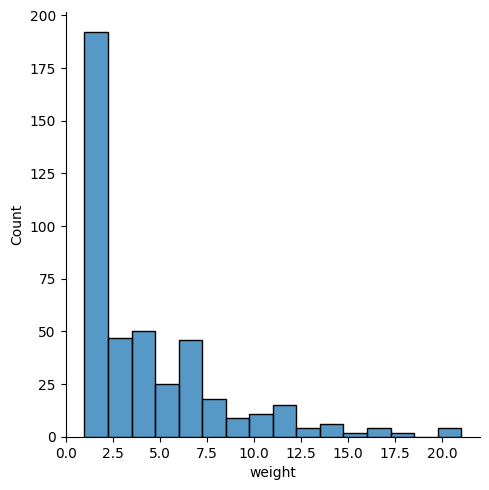

In [35]:
sns.displot(df_edges,x='weight')

<AxesSubplot:xlabel='pre_type', ylabel='weight'>

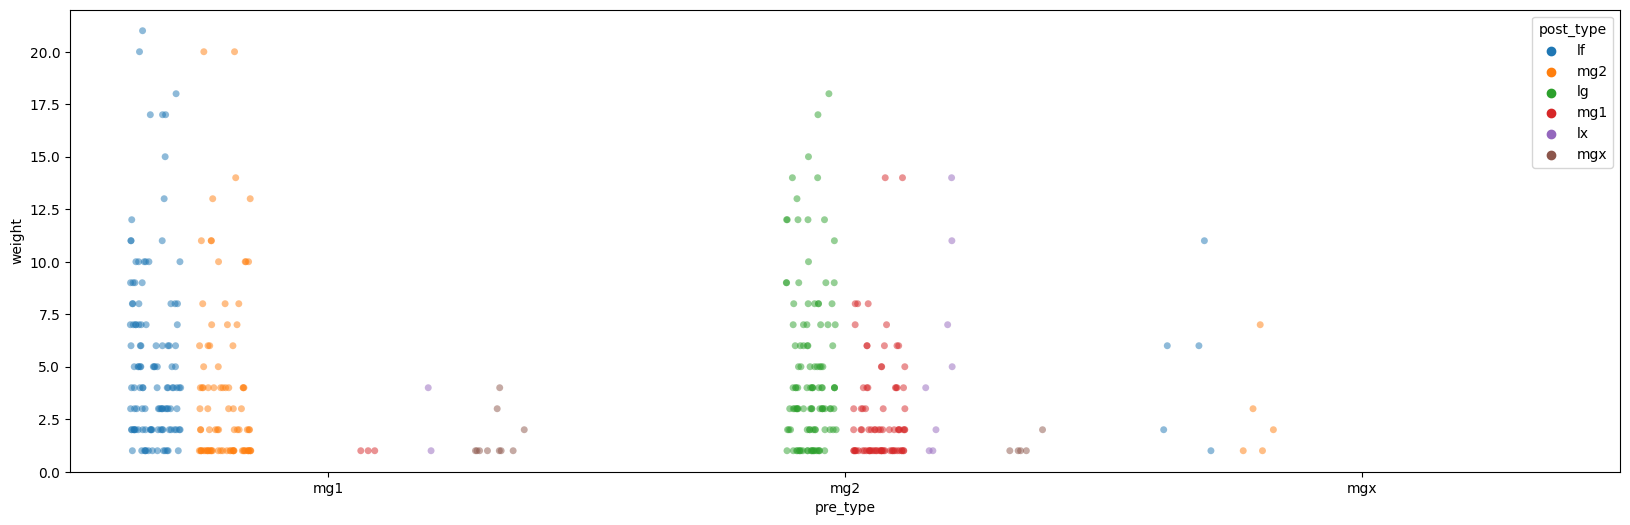

In [57]:
# df_edges['weight'].hist(bins=20)
plt.figure(figsize=(20,6))
sns.stripplot(df_edges,x='pre_type',y='weight',hue='post_type',dodge=True, jitter=0.3,alpha = 0.5)#,split=True)
# sns.displot(df_edges,x='weight',hue='pre_type',multiple='dodge')

<AxesSubplot:xlabel='pre_type', ylabel='weight'>

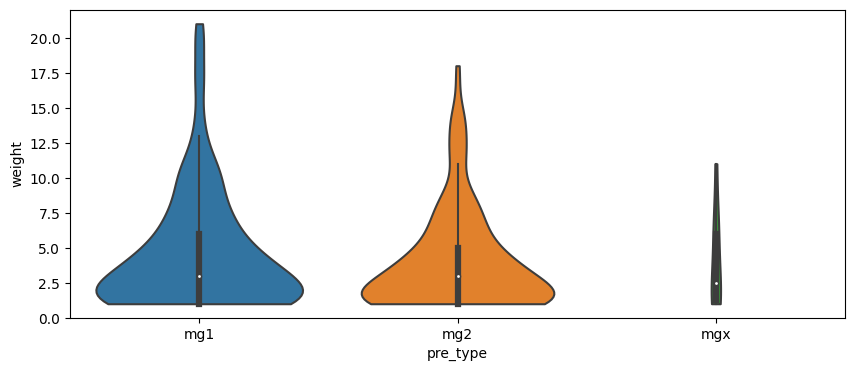

In [41]:
plt.figure(figsize=(10,4))
sns.violinplot(df_edges,x='pre_type',y='weight',scale='count',cut=0)
# plt.figure(figsize=(10,4))
# sns.kdeplot(df_edges,x='weight',hue='pre_type',bw_adjust = 0.5)

<AxesSubplot:xlabel='post_type', ylabel='weight'>

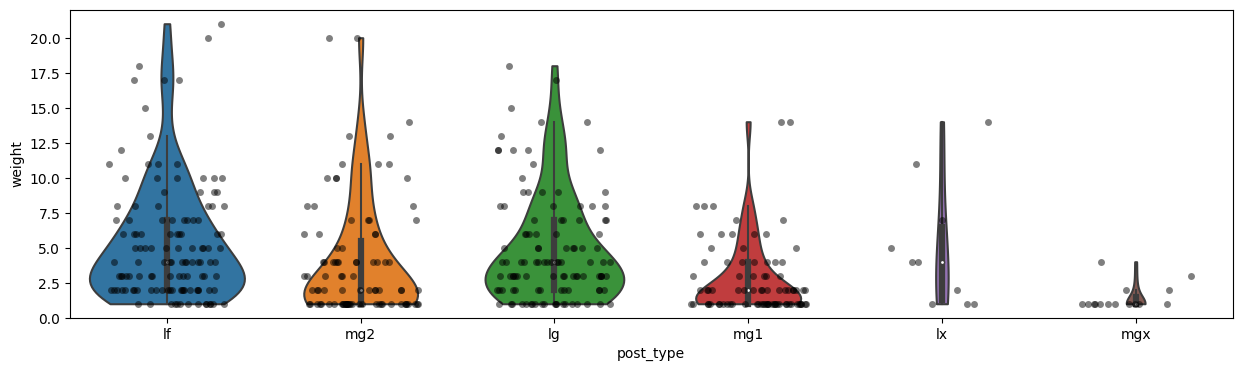

In [53]:
plt.figure(figsize=(15,4))
sns.violinplot(df_edges,x='post_type',y='weight',scale='count',cut=0)
sns.stripplot(df_edges,x='post_type',y='weight',color='black',alpha=0.5,jitter=0.3)
# plt.figure(figsize=(10,4))
# sns.kdeplot(df_edges,x='weight',hue='post_type',bw_adjust = 0.5)

In [43]:
degree_in = ell.degree(mode="in")
degree_out = ell.degree(mode="out")

df_degree = pd.DataFrame({
    'cell_id': [v['name'] for v in ell.vs],
    'converge': degree_in,
    'diverge': degree_out,
    'type': [cell_type[v['name']] for v in ell.vs]
})

with pd.option_context('display.max_rows', 4):
    display(df_degree)

,cell_id,converge,diverge,type
0,119793391,3,0,lg
1,126635405,4,10,mg1
...,...,...,...,...
142,652266299,3,0,lf
143,653504340,1,0,lf


<AxesSubplot:xlabel='type', ylabel='value'>

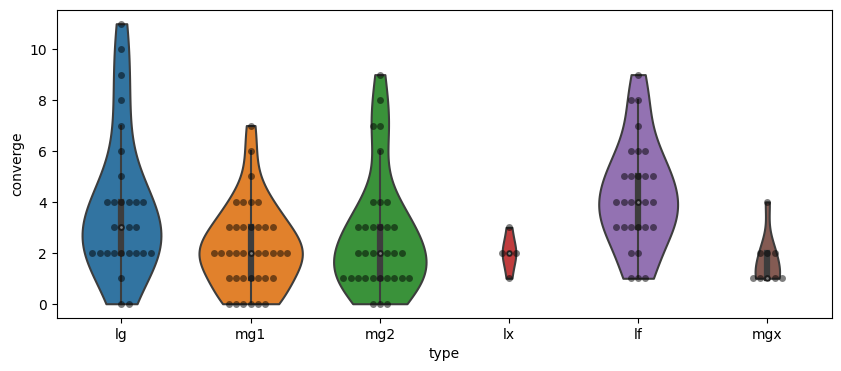

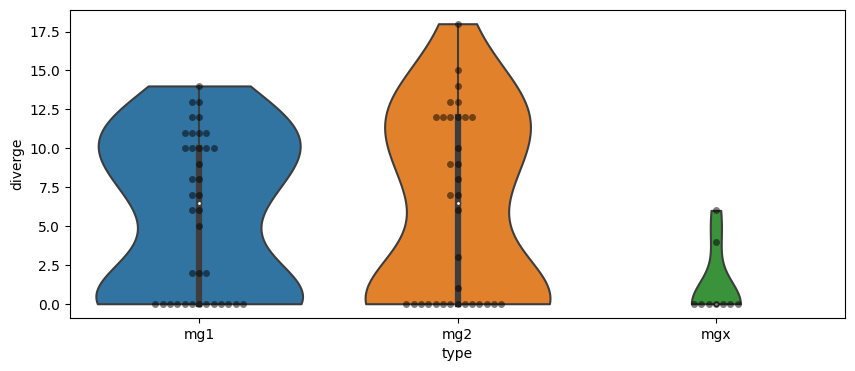

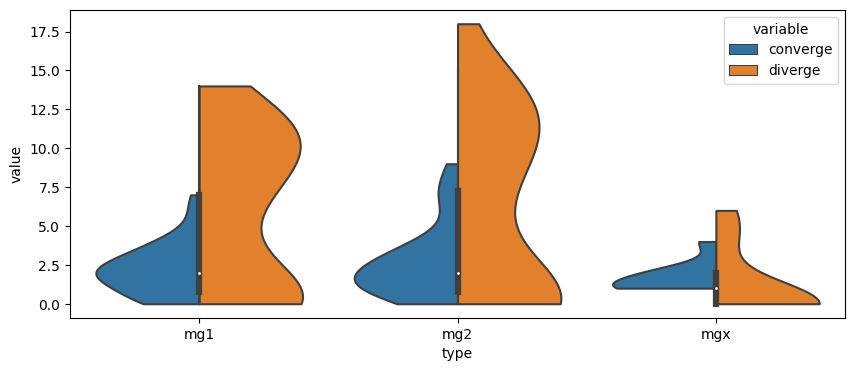

In [44]:
# sns.kdeplot(df_degree,x='converge',hue='type', bw_adjust = 0.75)
plt.figure(figsize=(10,4))
sns.violinplot(df_degree,x='type',y='converge',scale='count',cut=0)
# plt.figure(figsize=(10,4))
sns.swarmplot(df_degree,x='type',y='converge',color='black',alpha=0.5)#,jitter=0.25)
# sns.stripplot(df_degree,x='type',y='converge',alpha=0.5,jitter=0.25)

plt.figure(figsize=(10,4))
sns.violinplot(df_degree[df_degree['type'].isin(['mg1','mg2','mgx'])],y='diverge',x='type',scale='count',cut=0)
# plt.figure(figsize=(10,4))
sns.swarmplot(df_degree[df_degree['type'].isin(['mg1','mg2','mgx'])],x='type',y='diverge',color='black',alpha=0.5)



# sns.displot(df_degree[df_degree['type'].isin(['mg1','mg2','mgx'])],x='diverge',hue='type',multiple='dodge')

tmp = df_degree[df_degree['type'].isin(['mg1','mg2','mgx'])].melt(id_vars=['type'], 
            value_vars=['converge', 'diverge'])

plt.figure(figsize=(10,4))
sns.violinplot(tmp,y='value',x='type',hue = 'variable',split=True,scale='count',cut=0)

In [45]:
color_dict = {"mg1": "orange", "lf": "red", "mg2": "purple", "lg": "blue"}

# for cell_type in ell.vs["cell_type"]:

for v in ell.vs:
    try:
        v["color"] = color_dict[v['cell_type']]
    except:
        v["color"] = 'black'
# ell.vs["color"] = [try: color_dict[cell_type] except: 'black' for cell_type in ell.vs["cell_type"]]

In [46]:
color_dict = {"unknown": "brown", "apical dendrite": "red", "basal dendrite": "orange", "axon": "green", "multiple":"gray"}

# for cell_type in ell.vs["cell_type"]:

for e in ell.es:
    try:
        e["color"] = color_dict[e['structure']]
    except:
        e["color"] = 'black'
        # print(e)

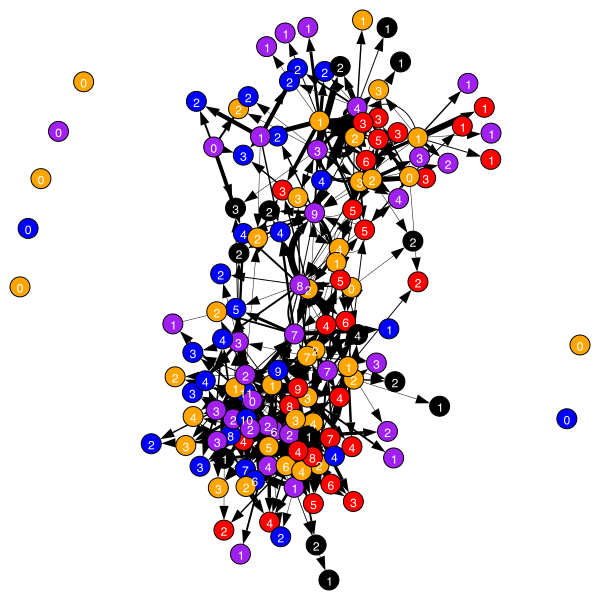

In [47]:
degree_all = ell.degree(mode="in")

# for i,d in enumerate(degree_all):
    # print(ell.vs[i]['cell_type'],d)

# labels = [n['name'] for n in ell.vs]

visual_style = {}
visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all
# visual_style["arrow_size"]=0.1


ig_plot(ell,edge_width = ell.es['weight'],
        vertex_color=ell.vs['color'],
        edge_color = ell.es['color'], 
        **visual_style)#,vertex_label=labels)

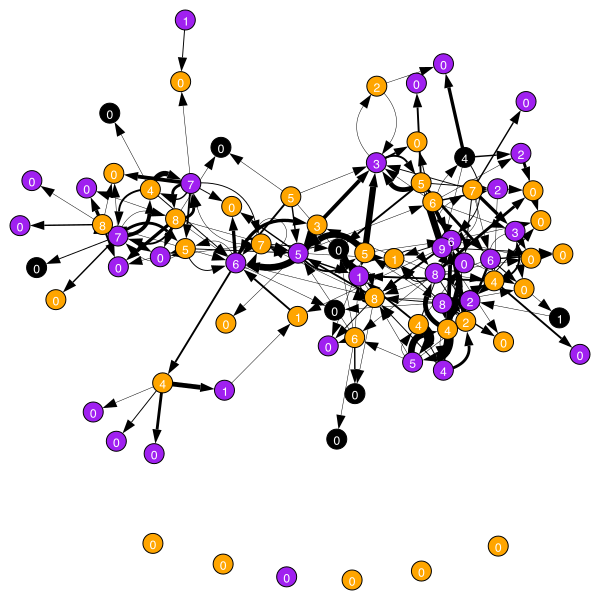

In [48]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if 'mg' in b['cell_type']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="out")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'],
        **visual_style)#,vertex_label=labels)

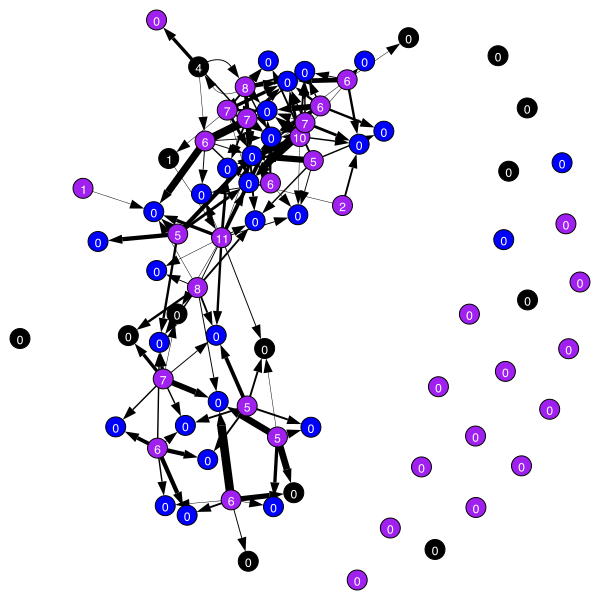

In [49]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if b['cell_type'] in ['mg2','mgx','lg','lx']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="out")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'], 
        **visual_style)#,vertex_label=labels)

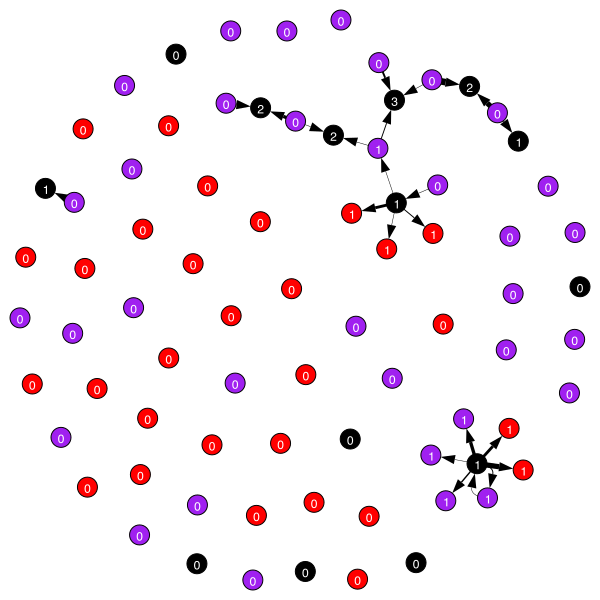

In [50]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if b['cell_type'] in ['mg2','mgx','lf','lx']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="in")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'], 
        **visual_style)#,vertex_label=labels)

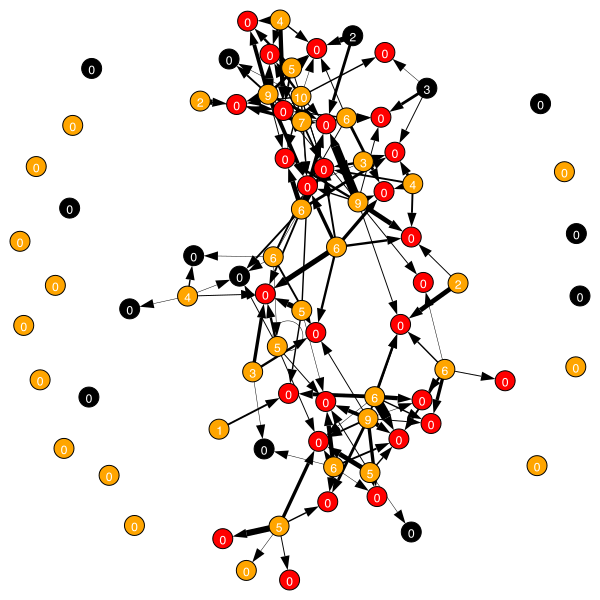

In [51]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if b['cell_type'] in ['mg1','mgx','lf','lx']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="out")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'], 
        **visual_style)#,vertex_label=labels)

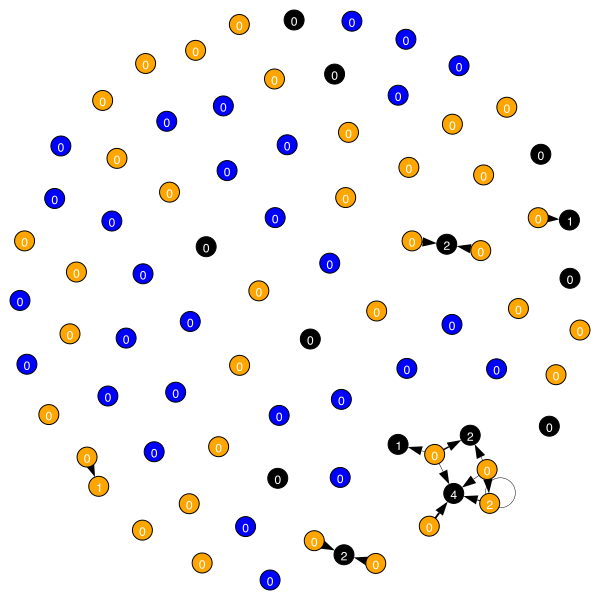

In [52]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if b['cell_type'] in ['mg1','mgx','lg','lx']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="in")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'], 
        **visual_style)#,vertex_label=labels)

## Get all pre-synaptic cells to a specific cellID

In [91]:
df_edges[df_edges['post']=='393063300'].groupby('pre').sum(numeric_only=True)

,weight,weight_norm
pre,,
214412684,12,3.0
300210608,2,0.5
387368998,4,1.0
472175645,20,5.0


## Check for duplicates in mg_network

In [78]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    

In [84]:
crest = ecrest(settings_dict,launch_viewer=False)

base_segments = crest.get_base_segments_dict(dirpath)

In [85]:
df_all = pd.DataFrame()
for k,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    df = cell.check_duplicates(base_segments)
    if not df.empty:
        df_all = pd.concat([df_all,df]) 
        
display(df_all)

""


## create crest files for post-syn segments not in cells

In [78]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    

In [86]:
# Create a base_segments dictionary of all cells

base_segments = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    base_segments[cell.cell_data['metadata']['main_seg']['base']] = cell.cell_data['base_segments']

In [ ]:
todo_dict= {}
post_segs_without_cell = 0
post_segs_with_cell = 0

all_syn = set()
for x_pre in nodes:
    pre = ecrest(settings_dict,filepath = nodefiles[x_pre],launch_viewer=False)

    # report if the cell is not cell-typed
    if (pre.get_ctype('manual') == []) | (pre.get_ctype('manual') == ''):
        print(f'cell {x_pre} is not cell-typed in json')
    
    # check if the cell is an mg cell and if it has post-synaptic segments labeled
    if ('mg' in pre.get_ctype('manual')) & (pre.cell_data['end_points']['post-synaptic'] != []):

        # for each synapse
        syn_to_find = set([syn_[3] for syn_ in pre.cell_data['end_points']['post-synaptic']])
        for x_post in nodes:
            post_segs = set([a for b in base_segments[x_post].values() for a in b])    
            syn_to_find = syn_to_find.difference(post_segs)
            
        all_syn = all_syn.union(syn_to_find)

for post_seg in list(all_syn):
    post = ecrest(settings_dict,segment_id = post_seg,launch_viewer=False)
    todo_dict[post_seg] = set(post.cell_data['base_segments']['unknown'])
    # post_segs_without_cell+=1

In [88]:
len(todo_dict)

930

In [89]:
topop=[]

todo_inds = list(todo_dict.keys())
for k,k_ in itertools.combinations(todo_inds,2):
    if todo_dict[k]&todo_dict[k_]!=set():
        # then they share segments
        topop.append(k_)
topop = np.unique(topop)

In [90]:
len(topop)

127

In [91]:
for segid in topop:
    todo_dict.pop(segid)
    

MAKE SURE THESE CELLS DO NOT OVERLAP WITH ALREADY DONE CELLS

In [93]:
topop=[]
reconstructed_segs={}
        
for todo_k,todo_v in todo_dict.items():
    for base_k, base_v in base_segments.items():
        all_base_v = set([a for b in base_v.values() for a in b])
        
        if set(todo_v) & all_base_v != set():
            # then the cell to do actually already exists in the mg_network... that cell is just missing segments!
            topop.append(todo_k)
            # print(f'already have this cell as {base_k}; so that cell must be missing segment {todo_k}')
            try: 
                reconstructed_segs[base_k].append(todo_k)
            except KeyError:
                reconstructed_segs[base_k] = [todo_k]
        # if set(todo_segs) & all_segs_base == set():
            
topop = np.unique(topop)            

In [94]:
len(topop)

26

In [95]:
for segid in topop:
    todo_dict.pop(segid)
    

create crest files for each of the unidentified post-synaptic partners

In [96]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

settings_dict['save_dir'] = Path(settings_dict['save_dir']) / 'todo_post-synaptic'

Save reconstructed_segs as a json to go through manually

In [101]:
json_path = Path(settings_dict['save_dir']) / 'reconstructed_missing_segs-2.json'
with open(json_path,'w') as fp:
    json.dump(reconstructed_segs, fp, indent=4)      

In [100]:
len(sorted(list(todo_dict.keys())))

777

Make sure the save_dir is what you want! (not the main folder, but a "todo" folder)

In [102]:
Path(settings_dict['save_dir'])

PosixPath('/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/todo_post-synaptic')

Loop through all "todo_dict" and make a crest file for them

In [ ]:
for segment_id in sorted(list(todo_dict.keys())):

    cell = ecrest(settings_dict,segment_id = segment_id, launch_viewer=False)
    cell.save_cell_graph()

check out the cells...
after completing one, make sure to check that it is not one of the currenlty "undone cells"

load one of the cells

In [275]:
filename = 'cell_graph_128473437__2023-04-07 19.33.39.json'
todo_cell = ecrest(settings_dict,filepath = Path(settings_dict['save_dir'])/filename,launch_viewer=True)



updating viewer status message: Current Base Segment Counts: unknown: 966, axon: 161, basal dendrite: 105, apical dendrite: 733, dendrite: 0, multiple: 9


In [270]:
todo_cell.define_ctype('lf','manual')
todo_cell.get_ctype('manual')

'mg2'

In [271]:
todo_cell.save_cell_graph()

Saved cell 128473437 reconstruction locally at 2023-04-08 06.08.54


### Check to make sure this cell is not already on the high priority sheet as "undone"

In [ ]:
undone_ids = [472282894,472114046,472284925,300459385,301339154]

undone_segs = {}
for bs in undone_ids:
    bs = str(bs)
    crest = ecrest(settings_dict,segment_id = bs,launch_viewer=False)
    undone_segs[bs] = [a for b in crest.cell_data['base_segments'].values() for a in b]

In [94]:
# if it is actually a new cell, this should return an empty set
duplicates_dict = {}
for undone_k, undone_v in undone_segs.items():
    for recon_k, recon_v in base_segments.items():
        recon_v = [a for b in recon_v.values() for a in b]
        if set(undone_v) & set(recon_v):
            duplicates_dict[undone_k]=recon_k
            

In [95]:
duplicates_dict

{'472282894': '472051969',
 '472114046': '472114046',
 '472284925': '472051969',
 '300459385': '300459385'}

In [99]:
crest = ecrest(settings_dict,segment_id = 472051969,launch_viewer=True)

Creating base segment graph for cell 472051969 Cell Reconstruction
all base locations for 3123 obtained from SQL database
graph created among all_base_segs
1 clusters of connected components. Connecting these clusters with nearest base segments.
weak clusters connected
segments without a location connected
1 clusters in graph (note should/would be only 1 if loaded base ID from agglomo fresh)
Created a CREST instance for NEW Reconstruction of 472051969. No file saved yet -- save manually.
updating viewer status message: Current Base Segment Counts: unknown: 3123, axon: 0, basal dendrite: 0, apical dendrite: 0, dendrite: 0, multiple: 0


## GET most recent files (by filename date) in folder

In [ ]:
dirname = 'C:/Users/mpetkova/Dropbox/U19_zebrafish/EMfullres/LateralLineCurlDetector/CREST/right_afferents/'
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:/Users/EngertLab/Dropbox/CREST/mariela_fish_credentials.json'

names = os.listdir(dirname);
cellid_filename=list();
for ind in range(len(names)):
    content = names[ind].split('_')
    if ('cell' in content):
        cellid_filename.append(names[ind])
d={}
for name in cellid_filename:
    ID,content_type,date=name.split('_')[2], name.split('_')[0], name.split('_')[-1]
    date=date[:-5]
    #create entry in dict which holds ID, file type (ex: cell_graph) and file path
    if ID not in d:
        d[ID]=[date, name]
        #if there are multiple files with the same ID, keep the info for the newest one
    else:
        if date>d[ID][0]:
            d[ID][0]=date
            d[ID][1]=name
            
############################################################################################################################ 
# Collect all the base segments for each ID
import json

base_segs = {}

for key in d.keys():
    f = open(dirname+d[key][1])
    data = json.load(f)
    base_segs[key]=sum(data['base_segments'].values(),[])
    f.close()

############################################################################################################################ 


## Fix cell_data dictionary keys


In [90]:
filepath = Path("/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/")
filepath = filepath / "cell_graph_305332461__2023-04-01 21.04.03.json"

In [91]:
cell = ecrest(settings_dict,filepath = filepath,launch_viewer=False)

In [92]:
old_points = cell.cell_data['end_points']
old_points

{'exit volume': [],
 'natural': [],
 'bad alignment': [],
 'uncorrected split': [],
 'artefact': [],
 'natural end': [],
 'uncertain': [],
 'pre-synaptic': [],
 'post-synaptic': []}

In [93]:
end_points = {}
for p in cell.point_types:
    # if p not in cell.cell_data['end_points']:
    end_points[p] = []
        
cell.cell_data['end_points'] = end_points

In [66]:
cell.cell_data['end_points']['natural end'] = old_points['natural']

In [94]:
# cell.cell_data['end_points'].pop('natural')
cell.cell_data['end_points'].keys()

dict_keys(['exit volume', 'natural end', 'uncertain', 'pre-synaptic', 'post-synaptic'])

In [95]:
cell.save_cell_graph(directory_path = filepath.parent, file_name=filepath.name, save_to_cloud=False); #rewrites the original, not with a new time stamp

Saved cell 305332461 reconstruction locally at 2023-04-05 11.20.24


## Figure out what is wrong with a crest file

In [125]:
filepath = Path("/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/")
filepath = filepath / "cell_graph_213605530__2023-03-29 22.49.21.json"
cell = ecrest(settings_dict,filepath = filepath,launch_viewer=False)

In [127]:
cell.cell_data['end_points']['post-synaptic']

[]

## Fix pre-synaptic to be post-synaptic annotation list in converted crest jsons

In [157]:
json_fix = Path("/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/Complete/synapses/to-crest/conversion_specs_synapse_fix.json")

with open(json_fix,'r') as f:
    cells_to_fix = f.read()
    cells_to_fix = json.loads(cells_to_fix)

In [158]:
cells_to_fix = cells_to_fix['cell_info']

In [163]:
for k,v in cells_to_fix.items():
    try:
        filepath = nodefiles[k]
        cell = ecrest(settings_dict,filepath = filepath,launch_viewer=False)
        cell.cell_data['end_points']['post-synaptic'] = deepcopy(cell.cell_data['end_points']['pre-synaptic'])

        cell.cell_data['end_points']['pre-synaptic'] = []
        # cell.save_cell_graph(directory_path = filepath.parent / 'original', file_name=filepath.name, save_to_cloud=False); #rewrites the original, not with a new time stamp
    except KeyError as msg:
        print(msg)
        continue
        

Saved cell 214412684 reconstruction locally at 2023-04-05 12.11.10
Saved cell 214550811 reconstruction locally at 2023-04-05 12.11.10
Saved cell 215572949 reconstruction locally at 2023-04-05 12.11.10
Saved cell 216129202 reconstruction locally at 2023-04-05 12.11.10
Saved cell 220275752 reconstruction locally at 2023-04-05 12.11.10
Saved cell 297178666 reconstruction locally at 2023-04-05 12.11.10
Saved cell 299497999 reconstruction locally at 2023-04-05 12.11.10
Saved cell 299589324 reconstruction locally at 2023-04-05 12.11.10
Saved cell 300210608 reconstruction locally at 2023-04-05 12.11.10
Saved cell 300316308 reconstruction locally at 2023-04-05 12.11.10
Saved cell 300380579 reconstruction locally at 2023-04-05 12.11.10
"305035439'"
Saved cell 31102601 reconstruction locally at 2023-04-05 12.11.10
Saved cell 387368998 reconstruction locally at 2023-04-05 12.11.10
Saved cell 392213717 reconstruction locally at 2023-04-05 12.11.10
Saved cell 42802314 reconstruction locally at 2023

In [150]:
cell.cell_data['end_points']

{'exit volume': [],
 'natural end': [[142609.46875, 275542.6875, 45.0],
  [142776.15625, 278173.6875, 2775.0],
  [53208.87890625, 271123.09375, 13365.0],
  [70813.0859375, 267435.34375, 10044.652404785156],
  [51008.359375, 284277.96875, 56675.0830078125],
  [68367.4921875, 273829.5625, 31418.91357421875],
  [64639.48046875, 274508.65625, 35085.003662109375],
  [62399.1796875, 303022.0625, 106049.47265625],
  [54059.69921875, 292912.375, 77115.0],
  [115337.7109375, 289251.84375, 74204.99267578125],
  [140118.015625, 284278.375, 106005.0],
  [142204.484375, 284977.09375, 106005.0],
  [111865.0390625, 291143.6875, 67154.99267578125],
  [110964.0390625, 289608.1875, 66825.0],
  [109141.9609375, 289524.5625, 66975.0],
  [106861.765625, 289384.875, 68985.0],
  [222726.3125, 265308.8125, 60494.996337890625],
  [185022.09375, 273914.90625, 45135.0],
  [184830.203125, 272752.84375, 52605.0],
  [169899.09375, 265474.03125, 13754.999084472656],
  [135296.546875, 277537.78125, 40934.996337890625

## Anatomical Clustering